# Laatste speeldag competitie 2024



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product, cycle
from math import isclose
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from collections import defaultdict

In [2]:
pd.set_option('display.max_columns', None) 

In [3]:
cols = ['club', 'P', 'WP', 'W', 'L', 'D', 'pp+', 'pp-']
data = [
    ['broekp', 3, 6, 3, 0, 0, 35, 19],
    ['duke', 3, 4, 2, 1, 0, 29, 25],
    ['haagsche', 4, 3, 1, 2, 1, 30, 42],
    ['eindh', 3, 2, 1, 2, 0, 29, 25],
    ['wouwse', 3, 1, 0, 2, 1, 21, 33],
]
stand = pd.DataFrame(data = data, columns = cols)
stand.set_index('club', inplace=True)
stand

,P,WP,W,L,D,pp+,pp-
club,,,,,,,
broekp,3,6,3,0,0,35,19
duke,3,4,2,1,0,29,25
haagsche,4,3,1,2,1,30,42
eindh,3,2,1,2,0,29,25
wouwse,3,1,0,2,1,21,33


In [4]:
wedstrijden = [
    'eindh_broekp',
    'wouwse_duke',
]
uitslagen = list(range(19))
data = list(product(uitslagen, uitslagen))
resultaat = pd.DataFrame(data, columns=wedstrijden)

In [5]:
for club in stand.index.values:
    resultaat[f'{club}_wp_start'] = stand.loc[club, 'WP']
    resultaat[f'{club}_pp+_start'] = stand.loc[club, 'pp+']
    resultaat[f'{club}_pp-_start'] = stand.loc[club, 'pp-']

In [6]:
for club in stand.index.values:
    resultaat[f'{club}_wp_extra'] = 0
    resultaat[f'{club}_pp+_extra'] = 0
    resultaat[f'{club}_pp-_extra'] = 0
    
    for wedstrijd in wedstrijden:
        if wedstrijd.startswith(club):
            resultaat[f'{club}_wp_extra'] += (resultaat[wedstrijd] > 9) * 2 + (resultaat[wedstrijd] == 9)
            resultaat[f'{club}_pp+_extra'] += resultaat[wedstrijd]
            resultaat[f'{club}_pp-_extra'] += 18 - resultaat[wedstrijd]
        elif wedstrijd.endswith(club):
            resultaat[f'{club}_wp_extra'] += (resultaat[wedstrijd] < 9) * 2 + (resultaat[wedstrijd] == 9)
            resultaat[f'{club}_pp+_extra'] += 18 - resultaat[wedstrijd]
            resultaat[f'{club}_pp-_extra'] += resultaat[wedstrijd]

    resultaat[f'{club}_wp'] = resultaat[f'{club}_wp_start'] + resultaat[f'{club}_wp_extra']
    resultaat[f'{club}_pp+'] = resultaat[f'{club}_pp+_start'] + resultaat[f'{club}_pp+_extra']
    resultaat[f'{club}_pp-'] = resultaat[f'{club}_pp-_start'] + resultaat[f'{club}_pp-_extra']

wp_ppp_kolommen = list()
for club in stand.index.values:
    resultaat[f'{club}_tot'] = resultaat[f'{club}_wp'] * 1000 + resultaat[f'{club}_pp+']
    wp_ppp_kolommen.append(f'{club}_tot')

In [7]:
resultaat[wedstrijden+wp_ppp_kolommen].head()

,eindh_broekp,wouwse_duke,broekp_tot,duke_tot,haagsche_tot,eindh_tot,wouwse_tot
0,0,0,8053,6047,3030,2029,1021
1,0,1,8053,6046,3030,2029,1022
2,0,2,8053,6045,3030,2029,1023
3,0,3,8053,6044,3030,2029,1024
4,0,4,8053,6043,3030,2029,1025


In [8]:
nun = resultaat[wp_ppp_kolommen].nunique(axis=1)
nun.value_counts()

5    354
4      7
Name: count, dtype: int64

In [9]:
resultaat.loc[nun==4, wedstrijden+wp_ppp_kolommen]

,eindh_broekp,wouwse_duke,broekp_tot,duke_tot,haagsche_tot,eindh_tot,wouwse_tot
28,1,9,8052,5038,3030,2030,2030
188,9,17,7044,4030,3030,3038,3038
194,10,4,6043,6043,3030,4039,1025
214,11,5,6042,6042,3030,4040,1026
234,12,6,6041,6041,3030,4041,1027
254,13,7,6040,6040,3030,4042,1028
274,14,8,6039,6039,3030,4043,1029


In [10]:
rank_cols = [c.replace('tot', 'rank') for c in wp_ppp_kolommen]
rank_cols

['broekp_rank', 'duke_rank', 'haagsche_rank', 'eindh_rank', 'wouwse_rank']

In [11]:
resultaat[rank_cols] = (
    resultaat[wp_ppp_kolommen].apply(
        lambda row: row.rank(method='min', ascending=False), axis=1)
)

# Gelijke rank aanpassen

- Broekpolder en Duke gedeeld eerste --> Duke wordt tweede
- Eindhoven en Wouwse gedeeld vierde --> Wouwse wordt vijfde
- Eindhoven en Wouwse gedeeld derde --> Wouwse wordt vierde

In [12]:
eindhoven_wouwse_gelijk = resultaat.eindh_rank == resultaat.wouwse_rank
broekpolder_duke_gelijk = resultaat.broekp_rank == resultaat.duke_rank

In [13]:
resultaat.loc[eindhoven_wouwse_gelijk, 'wouwse_rank'] += 1
resultaat.loc[broekpolder_duke_gelijk, 'duke_rank'] += 1

In [14]:
resultaat.groupby(rank_cols).size()

broekp_rank  duke_rank  haagsche_rank  eindh_rank  wouwse_rank
1.0          2.0        3.0            4.0         5.0            89
                                       5.0         4.0             1
                        4.0            3.0         5.0            34
                                       5.0         3.0            81
                        5.0            3.0         4.0             8
                                       4.0         3.0             1
             3.0        5.0            2.0         4.0            81
2.0          1.0        4.0            3.0         5.0            66
dtype: int64

# Maak target: haagsche_degradeert

Haagsche kan geen kampioen meer worden.

In [15]:
resultaat['haagsche_degradeert'] = (resultaat['haagsche_rank'] >= 4) * 1

In [16]:
# extra features
resultaat['wouwse_duke_gelijk'] = (resultaat.wouwse_duke == 9) * 1
resultaat['eindh_broekp_gelijk'] = (resultaat.eindh_broekp == 9) * 1

In [17]:
resultaat.describe()

,eindh_broekp,wouwse_duke,broekp_wp_start,broekp_pp+_start,broekp_pp-_start,duke_wp_start,duke_pp+_start,duke_pp-_start,haagsche_wp_start,haagsche_pp+_start,haagsche_pp-_start,eindh_wp_start,eindh_pp+_start,eindh_pp-_start,wouwse_wp_start,wouwse_pp+_start,wouwse_pp-_start,broekp_wp_extra,broekp_pp+_extra,broekp_pp-_extra,broekp_wp,broekp_pp+,broekp_pp-,duke_wp_extra,duke_pp+_extra,duke_pp-_extra,duke_wp,duke_pp+,duke_pp-,haagsche_wp_extra,haagsche_pp+_extra,haagsche_pp-_extra,haagsche_wp,haagsche_pp+,haagsche_pp-,eindh_wp_extra,eindh_pp+_extra,eindh_pp-_extra,eindh_wp,eindh_pp+,eindh_pp-,wouwse_wp_extra,wouwse_pp+_extra,wouwse_pp-_extra,wouwse_wp,wouwse_pp+,wouwse_pp-,broekp_tot,duke_tot,haagsche_tot,eindh_tot,wouwse_tot,broekp_rank,duke_rank,haagsche_rank,eindh_rank,wouwse_rank,haagsche_degradeert,wouwse_duke_gelijk,eindh_broekp_gelijk
count,361.000000,361.000000,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.0,361.0,361.0,361.0,361.0,361.0,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.0,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,9.000000,9.000000,6.0,35.0,19.0,4.0,29.0,25.0,3.0,30.0,42.0,2.0,29.0,25.0,1.0,21.0,33.0,1.000000,9.000000,9.000000,7.000000,44.000000,28.000000,1.000000,9.000000,9.000000,5.000000,38.000000,34.000000,0.0,0.0,0.0,3.0,30.0,42.0,1.000000,9.000000,9.000000,3.000000,38.000000,34.000000,1.000000,9.000000,9.000000,2.000000,30.000000,42.000000,7044.000000,5038.000000,3030.0,3038.000000,2030.000000,1.182825,2.041551,4.000000,3.479224,4.296399,0.750693,0.052632,0.052632
std,5.484828,5.484828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.974679,5.484828,5.484828,0.974679,5.484828,5.484828,0.974679,5.484828,5.484828,0.974679,5.484828,5.484828,0.0,0.0,0.0,0.0,0.0,0.0,0.974679,5.484828,5.484828,0.974679,5.484828,5.484828,0.974679,5.484828,5.484828,0.974679,5.484828,5.484828,979.556064,979.556064,0.0,979.556064,979.556064,0.387060,0.637654,0.707107,1.075089,0.815280,0.433213,0.223607,0.223607
min,0.000000,0.000000,6.0,35.0,19.0,4.0,29.0,25.0,3.0,30.0,42.0,2.0,29.0,25.0,1.0,21.0,33.0,0.000000,0.000000,0.000000,6.000000,35.000000,19.000000,0.000000,0.000000,0.000000,4.000000,29.000000,25.000000,0.0,0.0,0.0,3.0,30.0,42.0,0.000000,0.000000,0.000000,2.000000,29.000000,25.000000,0.000000,0.000000,0.000000,1.000000,21.000000,33.000000,6035.000000,4029.000000,3030.0,2029.000000,1021.000000,1.000000,1.000000,3.000000,2.000000,3.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,6.0,35.0,19.0,4.0,29.0,25.0,3.0,30.0,42.0,2.0,29.0,25.0,1.0,21.0,33.0,0.000000,4.000000,4.000000,6.000000,39.000000,23.000000,0.000000,4.000000,4.000000,4.000000,33.000000,29.000000,0.0,0.0,0.0,3.0,30.0,42.0,0.000000,4.000000,4.000000,2.000000,33.000000,29.000000,0.000000,4.000000,4.000000,1.000000,25.000000,37.000000,6039.000000,4033.000000,3030.0,2033.000000,1025.000000,1.000000,2.000000,4.000000,3.000000,4.000000,1.000000,0.000000,0.000000
50%,9.000000,9.000000,6.0,35.0,19.0,4.0,29.0,25.0,3.0,30.0,42.0,2.0,29.0,25.0,1.0,21.0,33.0,1.000000,9.000000,9.000000,7.000000,44.000000,28.000000,1.000000,9.000000,9.000000,5.000000,38.000000,34.000000,0.0,0.0,0.0,3.0,30.0,42.0,1.000000,9.000000,9.000000,3.000000,38.000000,34.000000,1.000000,9.000000,9.000000,2.000000,30.000000,42.000000,7044.000000,5038.000000,3030.0,3038.000000,2030.000000,1.000000,2.000000,4.000000,3.000000,5.000000,1.000000,0.000000,0.000000
75%,14.000000,14.000000,6.0,35.0,19.0,4.0,29.0,25.0,3.0,30.0,42.0,2.0,29.0,25.0,1.0,21.0,33.0,2.000000,14.000000,14.000000,8.000000,49.000000,33.000000,2.000000,14.000000,14.000000,6.000000,43.000000,39.000000,0.0,0.0,0.0,3.0,30.0,42.0,2.000000,14.000000,14.000000,4.000000,43

In [18]:
resultaat.sample(5)

,eindh_broekp,wouwse_duke,broekp_wp_start,broekp_pp+_start,broekp_pp-_start,duke_wp_start,duke_pp+_start,duke_pp-_start,haagsche_wp_start,haagsche_pp+_start,haagsche_pp-_start,eindh_wp_start,eindh_pp+_start,eindh_pp-_start,wouwse_wp_start,wouwse_pp+_start,wouwse_pp-_start,broekp_wp_extra,broekp_pp+_extra,broekp_pp-_extra,broekp_wp,broekp_pp+,broekp_pp-,duke_wp_extra,duke_pp+_extra,duke_pp-_extra,duke_wp,duke_pp+,duke_pp-,haagsche_wp_extra,haagsche_pp+_extra,haagsche_pp-_extra,haagsche_wp,haagsche_pp+,haagsche_pp-,eindh_wp_extra,eindh_pp+_extra,eindh_pp-_extra,eindh_wp,eindh_pp+,eindh_pp-,wouwse_wp_extra,wouwse_pp+_extra,wouwse_pp-_extra,wouwse_wp,wouwse_pp+,wouwse_pp-,broekp_tot,duke_tot,haagsche_tot,eindh_tot,wouwse_tot,broekp_rank,duke_rank,haagsche_rank,eindh_rank,wouwse_rank,haagsche_degradeert,wouwse_duke_gelijk,eindh_broekp_gelijk
65,3,8,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,2,15,3,8,50,22,2,10,8,6,39,33,0,0,0,3,30,42,0,3,15,2,32,40,0,8,10,1,29,43,8050,6039,3030,2032,1029,1.0,2.0,3.0,4.0,5.0,0,0,0
309,16,5,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,0,2,16,6,37,35,2,13,5,6,42,30,0,0,0,3,30,42,2,16,2,4,45,27,0,5,13,1,26,46,6037,6042,3030,4045,1026,2.0,1.0,4.0,3.0,5.0,1,0,0
225,11,16,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,0,7,11,6,42,30,0,2,16,4,31,41,0,0,0,3,30,42,2,11,7,4,40,32,2,16,2,3,37,35,6042,4031,3030,4040,3037,1.0,3.0,5.0,2.0,4.0,1,0,0
200,10,10,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,0,8,10,6,43,29,0,8,10,4,37,35,0,0,0,3,30,42,2,10,8,4,39,33,2,10,8,3,31,41,6043,4037,3030,4039,3031,1.0,3.0,5.0,2.0,4.0,1,0,0
312,16,8,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,0,2,16,6,37,35,2,10,8,6,39,33,0,0,0,3,30,42,2,16,2,4,45,27,0,8,10,1,29,43,6037,6039,3030,4045,1029,2.0,1.0,4.0,3.0,5.0,1,0,0


In [19]:
def make_model_etc(target, features, labels, fig_name):
    print(f'{target=}')

    X = resultaat[features]
    y = resultaat[target]

    model = DecisionTreeClassifier()
    model.fit(X, y)

    plt.figure(figsize=(10, 10))
    plot_tree(model, feature_names=features, class_names=labels, rounded=True, filled=True)
    plt.savefig(fig_name, dpi=800)
    plt.show()

    # check: should be 100% correct
    pred = model.predict(X)
    assert accuracy_score(resultaat[target], pred) == 1

In [20]:
fig_name = 'degradatie_laatste_speeldag.svg'

target = 'haagsche_degradeert'
labels = ['handhaving', 'degradatie']
features = wedstrijden + [
    'eindh_broekp_gelijk',
    'wouwse_duke_gelijk',
]

target='haagsche_degradeert'


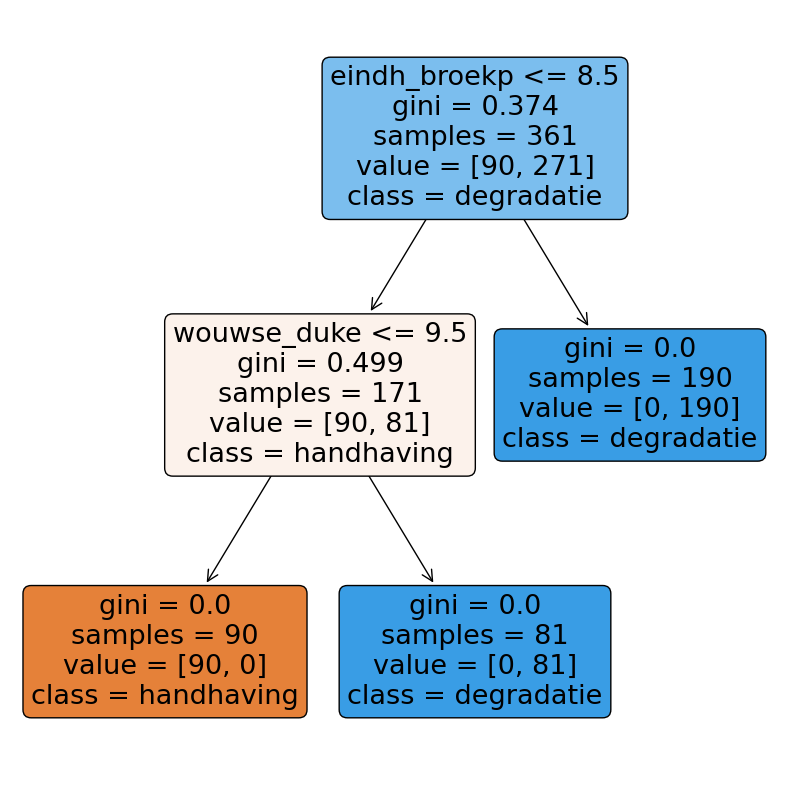

In [21]:
make_model_etc(target, features, labels, fig_name)

# Voeg kansen toe voor elk scenario

18-0 is minder waarschijnlijk dan 9-9 (net zoals dat 7 gooien met twee dobbelstenen waarschijnlijker is dan 12).

In [22]:
exact_handicaps = {
    'broekp': [-1.2, -0.6, -0.4, -0.4, 0.1, 0.2],
    'duke': [-1.5, -0.5, -0.1, 0.2, 0.7, 1.0],
    'eindh': [-2.5, -1.4, -1.2, 0.3, 0.7, 2.3],
    'wouwse': [-1.3, 1.3, 1.8, 2.2, 2.6, 2.9],
}
# voeg foursomes toe
for club, handicaps in exact_handicaps.items():
    foursomes = list(map(np.mean, zip(handicaps[::2], handicaps[1::2])))
    exact_handicaps[club] = foursomes + handicaps

exact_handicaps

{'broekp': [-0.8999999999999999,
  -0.4,
  0.15000000000000002,
  -1.2,
  -0.6,
  -0.4,
  -0.4,
  0.1,
  0.2],
 'duke': [-1.0, 0.05, 0.85, -1.5, -0.5, -0.1, 0.2, 0.7, 1.0],
 'eindh': [-1.95, -0.44999999999999996, 1.5, -2.5, -1.4, -1.2, 0.3, 0.7, 2.3],
 'wouwse': [0.0, 2.0, 2.75, -1.3, 1.3, 1.8, 2.2, 2.6, 2.9]}

In [23]:
std = 3  # aanname: iedereen zelfde spreiding van scores
max_score = 20  # score range van -1 * max_score tot max_score
points = [2, 1, 0]  # punten voor wins, draw, verlies

In [24]:
score_probs = dict()
for club, handicaps in exact_handicaps.items():
    partij = list()
    for handicap in handicaps:
        probs = [0]
        dist = norm(loc=handicap, scale=std)
        for score in range(-max_score, max_score+1):
            probs.append(dist.cdf(score))
        probs.append(1)
        partij.append(probs)
    score_probs[club] = partij

In [25]:
def win_draw_loss_kans_speler1(score_probs_p1, score_probs_p2):
    win = 0
    draw = 0
    loss = 0
    for i, (prob1_lo, prob1_hi, prob2_lo, prob2_hi) in enumerate(zip(score_probs_p1[:-1], score_probs_p1[1:], score_probs_p2[:-1], score_probs_p2[1:])):
        win += (prob1_hi - prob1_lo) * (1 - prob2_hi)
        draw += (prob1_hi - prob1_lo) * (prob2_hi - prob2_lo)
        loss += (prob1_hi - prob1_lo) * prob2_lo

    assert isclose(1, sum([win, draw, loss]))  # som van win, gelijk, verlies moet 1 zijn per partij
    
    return win, draw, loss

In [26]:
def get_punten_kans(club1, club2):
    wdl_all = [list(zip(points, win_draw_loss_kans_speler1(x, y))) for x, y in zip(score_probs[club1], score_probs[club2])]

    df = pd.DataFrame(data=product(*wdl_all))
    for i in range(9):
        df[[f'punten_{i}', f'kans_{i}']] = df[i].apply(pd.Series)

    punten_cols = [f'punten_{i}' for i in range(9)]
    kans_cols = [f'kans_{i}' for i in range(9)]
    df['som_punten'] = df[punten_cols].sum(axis=1).astype(np.int64)
    df[f'som_kans_{club1}_{club2}'] = df[kans_cols].prod(axis=1)

    return df.groupby('som_punten')[f'som_kans_{club1}_{club2}'].sum().to_frame()

In [27]:
for club1, club2 in map(lambda x: x.split('_'), wedstrijden):
    punten_kans_df = get_punten_kans(club1, club2)
    resultaat = resultaat.merge(punten_kans_df, how='left', left_on=f'{club1}_{club2}', right_index=True)

In [28]:
resultaat.head()

,eindh_broekp,wouwse_duke,broekp_wp_start,broekp_pp+_start,broekp_pp-_start,duke_wp_start,duke_pp+_start,duke_pp-_start,haagsche_wp_start,haagsche_pp+_start,haagsche_pp-_start,eindh_wp_start,eindh_pp+_start,eindh_pp-_start,wouwse_wp_start,wouwse_pp+_start,wouwse_pp-_start,broekp_wp_extra,broekp_pp+_extra,broekp_pp-_extra,broekp_wp,broekp_pp+,broekp_pp-,duke_wp_extra,duke_pp+_extra,duke_pp-_extra,duke_wp,duke_pp+,duke_pp-,haagsche_wp_extra,haagsche_pp+_extra,haagsche_pp-_extra,haagsche_wp,haagsche_pp+,haagsche_pp-,eindh_wp_extra,eindh_pp+_extra,eindh_pp-_extra,eindh_wp,eindh_pp+,eindh_pp-,wouwse_wp_extra,wouwse_pp+_extra,wouwse_pp-_extra,wouwse_wp,wouwse_pp+,wouwse_pp-,broekp_tot,duke_tot,haagsche_tot,eindh_tot,wouwse_tot,broekp_rank,duke_rank,haagsche_rank,eindh_rank,wouwse_rank,haagsche_degradeert,wouwse_duke_gelijk,eindh_broekp_gelijk,som_kans_eindh_broekp,som_kans_wouwse_duke
0,0,0,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,2,18,0,8,53,19,2,18,0,6,47,25,0,0,0,3,30,42,0,0,18,2,29,43,0,0,18,1,21,51,8053,6047,3030,2029,1021,1.0,2.0,3.0,4.0,5.0,0,0,0,0.00077,0.010119
1,0,1,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,2,18,0,8,53,19,2,17,1,6,46,26,0,0,0,3,30,42,0,0,18,2,29,43,0,1,17,1,22,50,8053,6046,3030,2029,1022,1.0,2.0,3.0,4.0,5.0,0,0,0,0.00077,0.013218
2,0,2,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,2,18,0,8,53,19,2,16,2,6,45,27,0,0,0,3,30,42,0,0,18,2,29,43,0,2,16,1,23,49,8053,6045,3030,2029,1023,1.0,2.0,3.0,4.0,5.0,0,0,0,0.00077,0.055823
3,0,3,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,2,18,0,8,53,19,2,15,3,6,44,28,0,0,0,3,30,42,0,0,18,2,29,43,0,3,15,1,24,48,8053,6044,3030,2029,1024,1.0,2.0,3.0,4.0,5.0,0,0,0,0.00077,0.058209
4,0,4,6,35,19,4,29,25,3,30,42,2,29,25,1,21,33,2,18,0,8,53,19,2,14,4,6,43,29,0,0,0,3,30,42,0,0,18,2,29,43,0,4,14,1,25,47,8053,6043,3030,2029,1025,1.0,2.0,3.0,4.0,5.0,0,0,0,0.00077,0.129439


In [29]:
resultaat['kans'] = resultaat[['som_kans_eindh_broekp', 'som_kans_wouwse_duke']].prod(axis=1)

# som alle mogelijkheden moet gelijk zijn aan 1
assert isclose(1, resultaat.groupby(rank_cols)['kans'].sum().sum())

In [30]:
# kans op elk scenario
resultaat.groupby(rank_cols)['kans'].sum()

broekp_rank  duke_rank  haagsche_rank  eindh_rank  wouwse_rank
1.0          2.0        3.0            4.0         5.0            0.397347
                                       5.0         4.0            0.000057
                        4.0            3.0         5.0            0.330922
                                       5.0         3.0            0.061418
                        5.0            3.0         4.0            0.015828
                                       4.0         3.0            0.000003
             3.0        5.0            2.0         4.0            0.056611
2.0          1.0        4.0            3.0         5.0            0.137814
Name: kans, dtype: float64

In [31]:
# kans op degraderen haagsche
resultaat.groupby('haagsche_degradeert')['kans'].sum()

haagsche_degradeert
0    0.397404
1    0.602596
Name: kans, dtype: float64